In [1]:
#Data Source: Loprinzi CL. Laurie JA. Wieand HS. Krook JE. Novotny PJ. Kugler JW. Bartel J. Law M. Bateman M. Klatt NE. et al. Prospective evaluation of prognostic variables from patient-completed questionnaires. North Central Cancer Treatment Group. Journal of Clinical Oncology. 12(3):601-7, 1994.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
from lifelines.utils import median_survival_times

In [3]:
data = pd.read_csv("lung.csv", index_col = 0)
data.head()

,inst,time,status,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss
1,3.0,306,2,74,1,1.0,90.0,100.0,1175.0,NaN
2,3.0,455,2,68,1,0.0,90.0,90.0,1225.0,15.0
3,3.0,1010,1,56,1,0.0,90.0,90.0,NaN,15.0
4,5.0,210,2,57,1,1.0,90.0,60.0,1150.0,11.0
5,1.0,883,2,60,1,0.0,100.0,90.0,NaN,0.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 228 entries, 1 to 228
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   inst       227 non-null    float64
 1   time       228 non-null    int64  
 2   status     228 non-null    int64  
 3   age        228 non-null    int64  
 4   sex        228 non-null    int64  
 5   ph.ecog    227 non-null    float64
 6   ph.karno   227 non-null    float64
 7   pat.karno  225 non-null    float64
 8   meal.cal   181 non-null    float64
 9   wt.loss    214 non-null    float64
dtypes: float64(6), int64(4)
memory usage: 19.6 KB


In [5]:
#inst: institution code
#time: survival time in days
#status: censoring status 0 = censored, 1 = dead
#age: in years
#sex: Male = 0 Female = 1
#ph.ecog: ECOG performance score as rated by the physician 0 = asymptomatic, 1 = symptomatic but completely ambulatory, 2 = in bed <50% of the day, 3 = in bed > 50% of the day but not bedbound, 4 = bedbound
#ph.karno: Karnofsky performance score (bad=0-good=100) rated by physician
#pat.karno: Karnofsky performance score as rated by patient
#meal.cal = Calories consumed at meals
#wt.loss = Weight loss in last six months

In [6]:
data = data[['time', 'status', 'age', 'sex', 'ph.ecog', 'ph.karno','pat.karno', 'meal.cal', 'wt.loss']]
data["status"] = data["status"] - 1
data["sex"] = data["sex"] - 1
data.head()

,time,status,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss
1,306,1,74,0,1.0,90.0,100.0,1175.0,NaN
2,455,1,68,0,0.0,90.0,90.0,1225.0,15.0
3,1010,0,56,0,0.0,90.0,90.0,NaN,15.0
4,210,1,57,0,1.0,90.0,60.0,1150.0,11.0
5,883,1,60,0,0.0,100.0,90.0,NaN,0.0


In [40]:
data.describe()

,time,status,age,sex,ph.karno,pat.karno,meal.cal,wt.loss,ecog_1,ecog_2
count,226.000000,226.000000,226.000000,226.00000,226.000000,226.000000,226.000000,226.000000,226.00000,226.000000
mean,307.097345,0.721239,62.424779,0.39823,82.132470,80.043658,926.821298,9.688694,0.50000,0.221239
std,210.624826,0.449385,9.098283,0.49062,12.179407,14.560155,359.035842,12.680080,0.50111,0.416002
min,5.000000,0.000000,39.000000,0.00000,50.000000,30.000000,96.000000,-24.000000,0.00000,0.000000
25%,170.750000,0.000000,56.000000,0.00000,80.000000,70.000000,768.000000,0.000000,0.00000,0.000000
50%,262.500000,1.000000,63.000000,0.00000,80.000000,80.000000,928.779006,8.000000,0.50000,0.000000
75%,401.500000,1.000000,69.000000,1.00000,90.000000,90.000000,1075.000000,15.000000,1.00000,0.000000
max,1022.000000,1.000000,82.000000,1.00000,100.000000,100.000000,2600.000000,68.000000,1.00000,1.000000


In [8]:
data.isnull().sum()

time          0
status        0
age           0
sex           0
ph.ecog       1
ph.karno      1
pat.karno     3
meal.cal     47
wt.loss      14
dtype: int64

In [9]:
data["ph.karno"].fillna(data["ph.karno"].mean(), inplace = True)
data["pat.karno"].fillna(data["pat.karno"].mean(), inplace = True)
data["meal.cal"].fillna(data["meal.cal"].mean(), inplace = True)
data["wt.loss"].fillna(data["wt.loss"].mean(), inplace = True)
data.dropna(inplace=True)
data["ph.ecog"] = data["ph.ecog"].astype("int64")

In [10]:
data.isnull().sum()

time         0
status       0
age          0
sex          0
ph.ecog      0
ph.karno     0
pat.karno    0
meal.cal     0
wt.loss      0
dtype: int64

<AxesSubplot:>

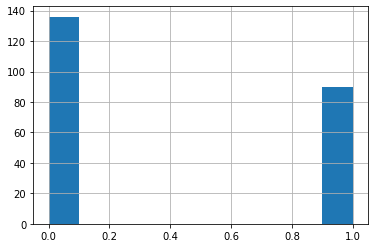

In [41]:
data["sex"].hist()

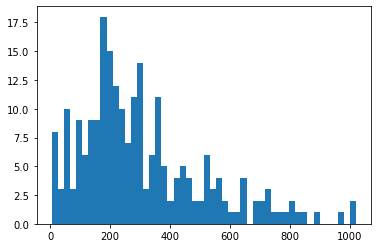

In [11]:
T = data["time"]
E = data["status"]
plt.hist(T, bins = 50)
plt.show()

<AxesSubplot:title={'center':'The Kaplan-Meier Estimate'}, xlabel='timeline'>

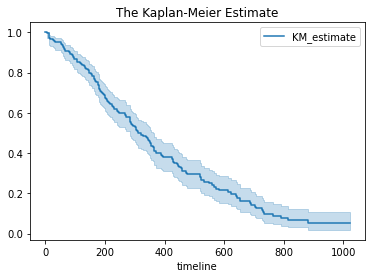

In [42]:
#Fitting a non-parametric model (Kaplan Meier Curve)
kmf = KaplanMeierFitter()
kmf.fit(durations = T, event_observed = E)
plt.title("The Kaplan-Meier Estimate")
kmf.plot_survival_function()

In [44]:
kmf.confidence_interval_

,KM_estimate_lower_0.95,KM_estimate_upper_0.95
0.0,1.000000,1.000000
5.0,0.969144,0.999378
11.0,0.953735,0.993350
12.0,0.947895,0.990773
13.0,0.936408,0.985179
...,...,...
840.0,0.030861,0.123582
883.0,0.017942,0.109120
965.0,0.017942,0.109120
1010.0,0.017942,0.109120


Text(0.5, 1.0, 'Survival Function')

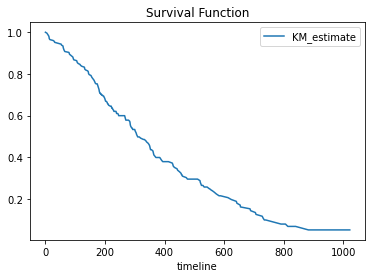

In [45]:
kmf.survival_function_.plot()
plt.title('Survival Function')

Text(0.5, 1.0, 'Death Function')

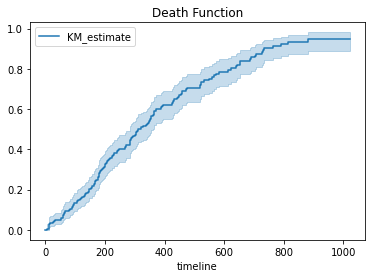

In [46]:
#probability of death
kmf.plot_cumulative_density()
plt.title("Death Function")

In [15]:
kmf.median_survival_time_

310.0

In [16]:
median_ = kmf.median_survival_time_
median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)
print(median_)
print(median_confidence_interval_)

310.0
     KM_estimate_lower_0.95  KM_estimate_upper_0.95
0.5                   284.0                   361.0


Text(0.5, 1.0, 'Survival of different gender group')

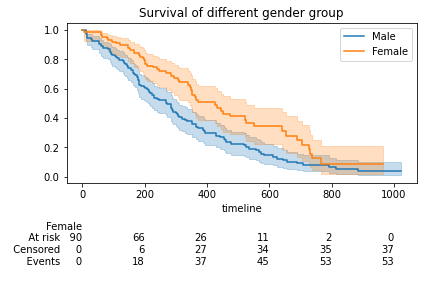

In [17]:
ax = plt.subplot(111)

m = (data["sex"] == 0)

kmf.fit(durations = T[m], event_observed = E[m], label = "Male")
kmf.plot_survival_function(ax = ax)

kmf.fit(T[~m], event_observed = E[~m], label = "Female")
kmf.plot_survival_function(ax = ax, at_risk_counts = True)

plt.title("Survival of different gender group")

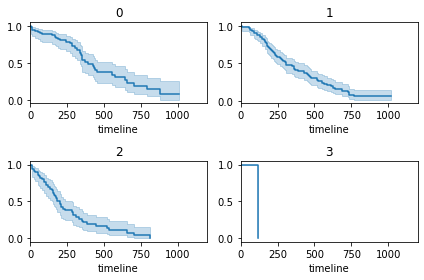

In [18]:
ecog_types = data.sort_values(by = ['ph.ecog'])["ph.ecog"].unique()

for i, ecog_types in enumerate(ecog_types):
    ax = plt.subplot(2, 2, i + 1)
    ix = data['ph.ecog'] == ecog_types
    kmf.fit(T[ix], E[ix], label = ecog_types)
    kmf.plot_survival_function(ax = ax, legend = False)
    plt.title(ecog_types)
    plt.xlim(0, 1200)

plt.tight_layout()

In [19]:
data['ph.ecog'].value_counts()

1    113
0     63
2     50
3      1
Name: ph.ecog, dtype: int64

In [20]:
data = data[data["ph.ecog"] != 3]
data.shape

(226, 9)

In [21]:
data['ph.ecog'].value_counts()

1    113
0     63
2     50
Name: ph.ecog, dtype: int64

In [22]:
#Fitting a non-parametric model (Cox proportional hazards model)
#even if the regression parameters (the betas) are known, the distribution of the outcome remains unknown

dummies_ecog = pd.get_dummies(data["ph.ecog"], prefix = 'ecog')
dummies_ecog.head(4)

,ecog_0,ecog_1,ecog_2
1,0,1,0
2,1,0,0
3,1,0,0
4,0,1,0


In [23]:
dummies_ecog = dummies_ecog[["ecog_1", "ecog_2"]]
data = pd.concat([data, dummies_ecog], axis = 1)
data.head()

,time,status,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss,ecog_1,ecog_2
1,306,1,74,0,1,90.0,100.0,1175.000000,9.831776,1,0
2,455,1,68,0,0,90.0,90.0,1225.000000,15.000000,0,0
3,1010,0,56,0,0,90.0,90.0,928.779006,15.000000,0,0
4,210,1,57,0,1,90.0,60.0,1150.000000,11.000000,1,0
5,883,1,60,0,0,100.0,90.0,928.779006,0.000000,0,0


In [24]:
data = data.drop("ph.ecog", axis = 1)
data.head()

,time,status,age,sex,ph.karno,pat.karno,meal.cal,wt.loss,ecog_1,ecog_2
1,306,1,74,0,90.0,100.0,1175.000000,9.831776,1,0
2,455,1,68,0,90.0,90.0,1225.000000,15.000000,0,0
3,1010,0,56,0,90.0,90.0,928.779006,15.000000,0,0
4,210,1,57,0,90.0,60.0,1150.000000,11.000000,1,0
5,883,1,60,0,100.0,90.0,928.779006,0.000000,0,0


In [25]:
cph = CoxPHFitter()
cph.fit(data, duration_col = 'time', event_col = 'status')

cph.print_summary()

<lifelines.CoxPHFitter: fitted with 226 total observations, 63 right-censored observations>
             duration col = 'time'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 226
number of events observed = 163
   partial log-likelihood = -721.02
         time fit was run = 2022-04-09 22:30:16 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
age         0.01       1.01       0.01            -0.01             0.03                 0.99                 1.03
sex        -0.58       0.56       0.17            -0.92            -0.25                 0.40                 0.78
ph.karno    0.02       1.02       0.01            -0.00             0.03                 1.00                 1.03
pat.karno  -0.01       0.99       0.01            -0.03             0.00                 0.97                 1.00
meal.cal    0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
wt.loss    -0.01       0.99       0.01            -0.02             0.00                 0.98                 1.00
ecog_1      0.62       1.86       0.24             0.15             1.09                 1.17                 2.97
ecog_2      1.20       3.31       0.37             0.46             1.93                 1.59                 6.89

            cmp to     z      p   -log2(p)
covariate                                 
age           0.00  1.33   0.18       2.44
sex           0.00 -3.41 <0.005      10.58
ph.karno      0.00  1.64   0.10       3.29
pat.karno     0.00 -1.77   0.08       3.70
meal.cal      0.00  0.06   0.95       0.07
wt.loss       0.00 -1.73   0.08       3.57
ecog_1        0.00  2.60   0.01       6.76
ecog_2        0.00  3.19 <0.005       9.46
---
Concordance = 0.65
Partial AIC = 1458.05
log-likelihood ratio test = 36.08 on 8 df
-log2(p) of ll-ratio test = 15.85

In [26]:
#Wt.loss has a coefficient of about -0.01
#in the Cox proportional hazard model, a higher hazard means more at risk of the event occurring
#value exp(-0.01) is called the hazard ratio
#a one unit increase in wt.loss means the baseline hazard will increase by a factor of exp(-0.01) = 0.99 - about a 1% decrease
#the values in the ecog column are: [0 = asymptomatic, 1 = symptomatic but completely ambulatory, 2 = in bed 50\% of the day]
#the value of the coefficient associated with ecog2 is the value of ratio of hazards associated with being "in bed 50% of the day (coded as 2)" compared to asymptomatic (coded as 0, base category)

<AxesSubplot:xlabel='log(HR) (95% CI)'>

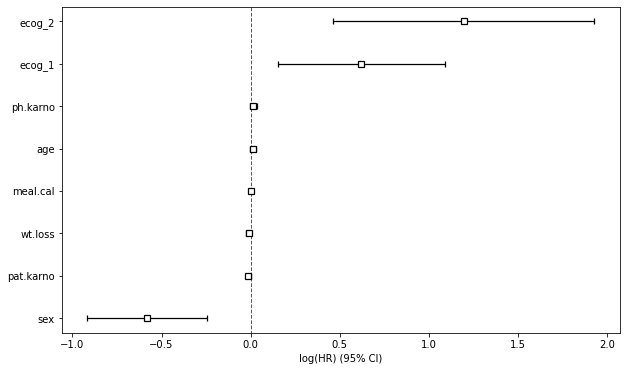

In [27]:
plt.subplots(figsize=(10, 6))
cph.plot()

<AxesSubplot:>

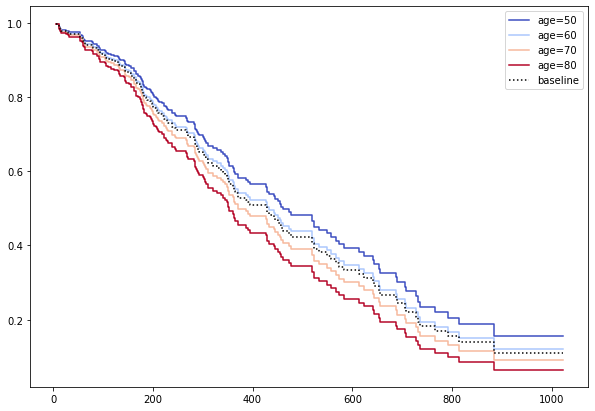

In [31]:
cph.plot_partial_effects_on_outcome(covariates = 'age', values = [50, 60, 70, 80], cmap = 'coolwarm', figsize=(10,7))

In [32]:
cph.check_assumptions(data, p_value_threshold = 0.05)

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



C:\Users\likandakji\Anaconda3\lib\site-packages\lifelines\fitters\mixins.py:108: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  for variable in self.params_.index & (columns or self.params_.index):


<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 226 total observations, 63 right-censored observations>
         test_name = proportional_hazard_test

---
                test_statistic    p  -log2(p)
age       km              0.42 0.52      0.95
          rank            0.18 0.67      0.58
ecog_1    km              1.57 0.21      2.25
          rank            1.41 0.23      2.09
ecog_2    km              1.20 0.27      1.87
          rank            0.86 0.35      1.50
meal.cal  km              5.32 0.02      5.57
          rank            4.73 0.03      5.08
pat.karno km              0.22 0.64      0.64
          rank            0.17 0.68      0.55
ph.karno  km              3.62 0.06      4.13
          rank            3.07 0.08      3.65
sex       km              2.62 0.11      3.25
          rank            2.50 0.11      3.14
wt.loss   km              0.02 0.89      0.17
          rank            0.06 0.81      0.31



1. Variable 'meal.cal' failed the non-proportional test: p-value is 0.0210.

   Advice 1: the functional form of the variable 'meal.cal' might be incorrect. That is, there may
be non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'meal.cal' using pd.cut, and then specify it in
`strata=['meal.cal', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#

[]

In [33]:
from lifelines.statistics import proportional_hazard_test

results = proportional_hazard_test(cph, data, time_transform='rank')
results.print_summary(decimals=3, model="untransformed variables")

<lifelines.StatisticalResult: proportional_hazard_test>
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 226 total observations, 63 right-censored observations>
         test_name = proportional_hazard_test

---
           test_statistic    p  -log2(p)
age                  0.18 0.67      0.58
ecog_1               1.41 0.23      2.09
ecog_2               0.86 0.35      1.50
meal.cal             4.73 0.03      5.08
pat.karno            0.17 0.68      0.55
ph.karno             3.07 0.08      3.65
sex                  2.50 0.11      3.14
wt.loss              0.06 0.81      0.31

In [34]:
#Parametric Accelerated Failure Time Model (AFT)

from lifelines import WeibullFitter,\
                      ExponentialFitter,\
                      LogNormalFitter,\
                      LogLogisticFitter


# Instantiate each fitter
wb = WeibullFitter()
ex = ExponentialFitter()
log = LogNormalFitter()
loglogis = LogLogisticFitter()

# Fit to data
for model in [wb, ex, log, loglogis]:
  model.fit(durations = data["time"],
            event_observed = data["status"])
  # Print AIC
  print("The AIC value for", model.__class__.__name__, "is",  model.AIC_)

The AIC value for WeibullFitter is 2286.140229521957
The AIC value for ExponentialFitter is 2301.5875633782243
The AIC value for LogNormalFitter is 2318.111808285761
The AIC value for LogLogisticFitter is 2300.6601651026126


In [35]:
from lifelines import WeibullAFTFitter
weibull_aft = WeibullAFTFitter()
weibull_aft.fit(data, duration_col='time', event_col='status')

weibull_aft.print_summary(3)

<lifelines.WeibullAFTFitter: fitted with 226 total observations, 63 right-censored observations>
             duration col = 'time'
                event col = 'status'
   number of observations = 226
number of events observed = 163
           log-likelihood = -1122.980
         time fit was run = 2022-04-09 22:35:09 UTC

---
                    coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param   covariate                                                                                                         
lambda_ age       -0.009      0.992      0.007           -0.022            0.005                0.978                1.005
        ecog_1    -0.445      0.641      0.167           -0.773           -0.117                0.462                0.889
        ecog_2    -0.878      0.416      0.263           -1.393           -0.363                0.248                0.695
        meal.cal   0.000      1.000      0.000           -0.000            0.000                1.000                1.000
        pat.karno  0.009      1.009      0.005           -0.001            0.019                0.999                1.019
        ph.karno  -0.012      0.988      0.007           -0.025            0.001                0.975                1.001
        sex        0.416      1.516      0.123            0.175            0.657                1.192                1.928
        wt.loss    0.008      1.008      0.005           -0.001            0.017                0.999                1.017
        Intercept  7.003   1100.221      0.887            5.266            8.741              193.552             6254.062
rho_    Intercept  0.338      1.402      0.062            0.216            0.460                1.241                1.584

                    cmp to      z       p   -log2(p)
param   covariate                                   
lambda_ age          0.000 -1.259   0.208      2.266
        ecog_1       0.000 -2.662   0.008      7.010
        ecog_2       0.000 -3.344   0.001     10.242
        meal.cal     0.000  0.021   0.983      0.024
        pat.karno    0.000  1.787   0.074      3.757
        ph.karno     0.000 -1.831   0.067      3.896
        sex          0.000  3.389   0.001     10.476
        wt.loss      0.000  1.713   0.087      3.527
        Intercept    0.000  7.899 <0.0005     48.337
rho_    Intercept    0.000  5.442 <0.0005     24.177
---
Concordance = 0.649
AIC = 2265.960
log-likelihood ratio test = 36.180 on 8 df
-log2(p) of ll-ratio test = 15.907

In [36]:
print(weibull_aft.median_survival_time_)
print(weibull_aft.mean_survival_time_)

419.097464956523
495.96975466422657


<AxesSubplot:xlabel='log(accelerated failure rate) (95% CI)'>

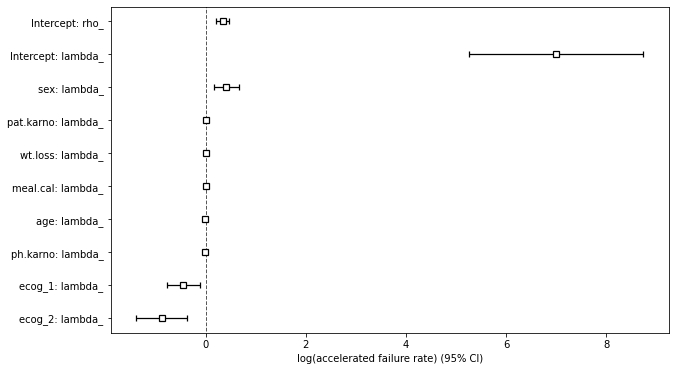

In [37]:
plt.subplots(figsize=(10, 6))
weibull_aft.plot()

<AxesSubplot:title={'center':'Survival of different age groups'}>

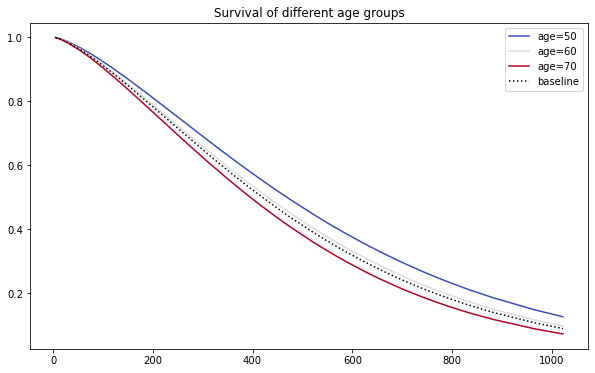

In [39]:
plt.subplots(figsize=(10, 6))
plt.title("Survival of different age groups")
weibull_aft.plot_partial_effects_on_outcome('age', range(50, 80, 10), cmap='coolwarm')